In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
import kerastuner as kt
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Funktion zur Berechnung der Mandelbrot-Iteration
def mandelbrot(c, max_iter):
    z = c
    for n in range(max_iter):
        if abs(z) > 2:
            return n
        z = z*z + c
    return max_iter

# Funktion zur Generierung der Daten
def generate_data(grid_size, max_iter):
    real = np.linspace(-2, 2, grid_size)
    imag = np.linspace(-2, 2, grid_size)
    data = []
    for re in real:
        for im in imag:
            c = complex(re, im)
            iter_count = mandelbrot(c, max_iter)
            data.append([re, im, iter_count])
    return np.array(data)

# Parameter für die Datenvorbereitung
grid_size = 512  # Feinheit des Gitters
max_iter = 1000  # Maximale Iterationen


In [21]:

# Generierung der Daten
data = generate_data(grid_size, max_iter)

# Aufteilen der Daten in Trainings-, Validierungs- und Testdaten
X = data[:, :2]  # Real- und Imaginärteil
y = data[:, 2]   # Anzahl der Iterationen

# Aufteilen der Daten
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [10]:


# Hypermodel für FCNN definieren
class FCNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                        activation='relu', input_dim=2))
        model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32),
                        activation='relu'))
        model.add(Dense(1, activation='linear'))
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Tuner erstellen
tuner_fcnn = RandomSearch(
    FCNNHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='modelle',
    project_name='FCNN'
)

# Suche nach den besten Hyperparametern
tuner_fcnn.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Reloading Tuner from my_dir\FCNN\tuner0.json


In [11]:
# Beste Hyperparameter anzeigen
best_hps_fcnn = tuner_fcnn.get_best_hyperparameters(num_trials=1)[0]
print(f'Beste Hyperparameter für FCNN: {best_hps_fcnn.values}')

# Beste Modell trainieren
best_model_fcnn = tuner_fcnn.hypermodel.build(best_hps_fcnn)
best_model_fcnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Bewertung des FCNN-Modells
y_pred_fcnn = best_model_fcnn.predict(X_test)
mse_fcnn = mean_squared_error(y_test, y_pred_fcnn)
print(f'MSE Neural Network: {mse_fcnn}')


Beste Hyperparameter für FCNN: {'units_1': 512, 'units_2': 256}
Epoch 1/10


c:\Users\simon\Music\ML_abgabe\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 45714.9141 - val_loss: 16415.7227
Epoch 2/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 14970.1035 - val_loss: 14605.7061
Epoch 3/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 13387.8535 - val_loss: 12670.1328
Epoch 4/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 13014.9492 - val_loss: 12374.4307
Epoch 5/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 12442.3047 - val_loss: 11910.1318
Epoch 6/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 11696.2158 - val_loss: 11569.7920
Epoch 7/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 11379.9902 - val_loss: 10905.1602
Epoch 8/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 10517.8555 - val_loss: 10815.8633
Epoch 9/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 10028.6279 - val_loss: 9811.2559
Epoch 10/10
4916/4916 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 9369.5869 - val_loss: 9598.3916
1639/1639 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [22]:
# Retrieve all trial results
trials = tuner_fcnn.oracle.trials

# Display each trial's ID, hyperparameters, and score
for trial_id, trial in trials.items():
    print(f"Trial ID: {trial_id}, Hyperparameters: {trial.hyperparameters.values}, Score: {trial.score}")


Trial ID: 02, Hyperparameters: {'units_1': 192, 'units_2': 32}, Score: 12412.74951171875
Trial ID: 05, Hyperparameters: {'units_1': 480, 'units_2': 480}, Score: 9667.81591796875
Trial ID: 01, Hyperparameters: {'units_1': 512, 'units_2': 256}, Score: 9450.64111328125
Trial ID: 09, Hyperparameters: {'units_1': 512, 'units_2': 320}, Score: 9657.52783203125
Trial ID: 07, Hyperparameters: {'units_1': 32, 'units_2': 320}, Score: 12906.31591796875
Trial ID: 08, Hyperparameters: {'units_1': 128, 'units_2': 160}, Score: 13029.28955078125
Trial ID: 03, Hyperparameters: {'units_1': 288, 'units_2': 64}, Score: 11474.54443359375
Trial ID: 04, Hyperparameters: {'units_1': 96, 'units_2': 480}, Score: 12036.90234375
Trial ID: 06, Hyperparameters: {'units_1': 416, 'units_2': 352}, Score: 10573.17724609375
Trial ID: 00, Hyperparameters: {'units_1': 256, 'units_2': 128}, Score: 11368.88916015625


In [23]:

# Vorbereitung der Daten für das CNN
def prepare_data(grid_size, data):
    data_cnn = np.zeros((grid_size, grid_size))
    for i, (re, im, iter_count) in enumerate(data):
        x = i // grid_size
        y = i % grid_size
        data_cnn[x, y] = iter_count
    return data_cnn

# Hypermodel für das CNN definieren
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential([
            Conv2D(hp.Int('filters_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(grid_size, grid_size, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(hp.Int('filters_2', min_value=64, max_value=128, step=32), (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(hp.Int('filters_3', min_value=64, max_value=128, step=32), (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(grid_size // 8 * grid_size // 8, activation='linear'),
            Reshape((grid_size // 8, grid_size // 8, 1)),
            UpSampling2D(size=(8, 8))
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Parameter für die Datenvorbereitung
grid_size = 512
max_iter = 1000

# Daten generieren und vorbereiten
data = generate_data(grid_size, max_iter)
data_cnn = prepare_data(grid_size, data)

X_cnn = data_cnn.reshape((1, grid_size, grid_size, 1))  # Batch-Dimension hinzufügen
y_cnn = data_cnn.reshape((1, grid_size, grid_size, 1))

# Erstellen des Tuners
tuner = RandomSearch(
    CNNHyperModel(),
    objective='loss',
    max_trials=4,
    executions_per_trial=2,
    directory='modelle',
    project_name='CNN'
)

# Suche nach den besten Hyperparametern
tuner.search(X_cnn, y_cnn, epochs=100, batch_size=20)



Trial 5 Complete [00h 10m 10s]
loss: 4447.236328125

Best loss So Far: 4446.295654296875
Total elapsed time: 02h 16m 52s


In [24]:
# Beste Hyperparameter ausgeben und Modell trainieren
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Beste Hyperparameter: {best_hps.values}')

best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_cnn, y_cnn, epochs=100, batch_size=10)

# Vorhersage und Berechnung des MSE
y_pred_cnn = best_model.predict(X_cnn)
y_pred_cnn = y_pred_cnn.reshape((grid_size, grid_size))
mse = mean_squared_error(data_cnn, y_pred_cnn)
print(f'MSE Convolutional Neural Network: {mse}')


Beste Hyperparameter: {'filters_1': 32, 'filters_2': 128, 'filters_3': 64}
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 94290.8672
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 129806.5078
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 89260.5234
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 93059.6953
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 93145.0234
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - loss: 92768.4375
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - loss: 91872.1406
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 90050.7031
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 86630.2031
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - loss: 81024.7266
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 72782.1328
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 62401.3320
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 52094.8242
Epoch 14/100


In [26]:
# Retrieve all trial results
trials = tuner.oracle.trials

# Display each trial's ID, hyperparameters, and score
for trial_id, trial in trials.items():
    print(f"Trial ID: {trial_id}, Hyperparameters: {trial.hyperparameters.values}, Score: {trial.score}")


Trial ID: 2, Hyperparameters: {'filters_1': 32, 'filters_2': 96, 'filters_3': 64}, Score: 4446.331298828125
Trial ID: 3, Hyperparameters: {'filters_1': 32, 'filters_2': 128, 'filters_3': 64}, Score: 4446.295654296875
Trial ID: 4, Hyperparameters: {'filters_1': 128, 'filters_2': 128, 'filters_3': 96}, Score: 4447.236328125
Trial ID: 0, Hyperparameters: {'filters_1': 64, 'filters_2': 64, 'filters_3': 128}, Score: 4449.07470703125
Trial ID: 1, Hyperparameters: {'filters_1': 32, 'filters_2': 64, 'filters_3': 128}, Score: 4448.161865234375


C:\Users\simon\AppData\Local\Temp\ipykernel_4600\3848519828.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_fcnn_grid[x, y] = y_pred_fcnn[idx]


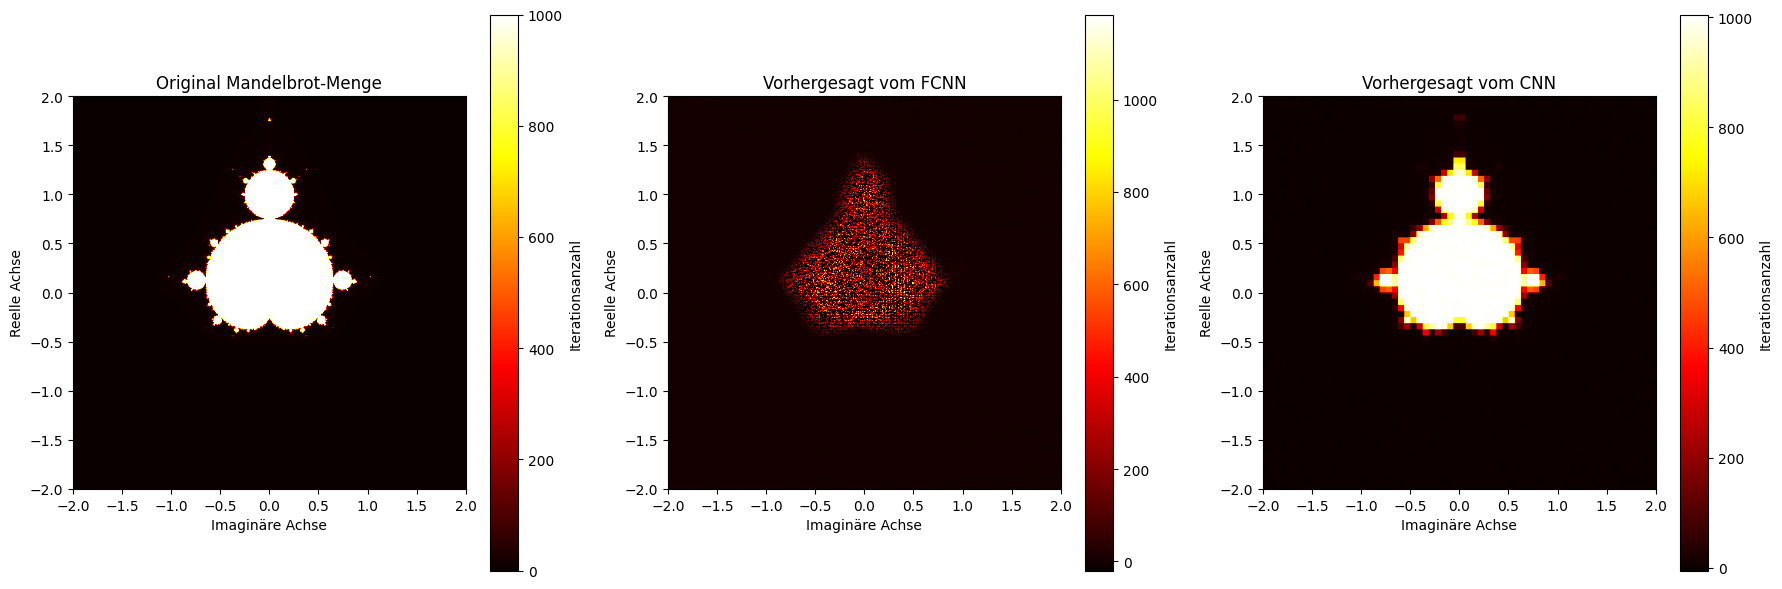

In [25]:

plt.figure(figsize=(18, 6))

# Original Mandelbrot-Menge
plt.subplot(1, 3, 1)
plt.title("Original Mandelbrot-Menge")
plt.imshow(data_cnn, cmap='hot', extent=[-2, 2, -2, 2])
plt.colorbar(label='Iterationsanzahl')
plt.xlabel('Imaginäre Achse')
plt.ylabel('Reelle Achse')

# Vorhersage des FCNN
plt.subplot(1, 3, 2)
plt.title("Vorhergesagt vom FCNN")
y_pred_fcnn_grid = np.zeros((grid_size, grid_size))
for idx, (re, im) in enumerate(X_test):
    x = int((re + 2) / 4 * (grid_size - 1))
    y = int((im + 2) / 4 * (grid_size - 1))
    y_pred_fcnn_grid[x, y] = y_pred_fcnn[idx]
plt.imshow(y_pred_fcnn_grid, cmap='hot', extent=[-2, 2, -2, 2])
plt.colorbar(label='Iterationsanzahl')
plt.xlabel('Imaginäre Achse')
plt.ylabel('Reelle Achse')

# Vorhersage des CNN
plt.subplot(1, 3, 3)
plt.title("Vorhergesagt vom CNN")
plt.imshow(y_pred_cnn, cmap='hot', extent=[-2, 2, -2, 2])
plt.colorbar(label='Iterationsanzahl')
plt.xlabel('Imaginäre Achse')
plt.ylabel('Reelle Achse')

# Verbesserung des Layouts
plt.tight_layout()
plt.show()